<a href="https://colab.research.google.com/github/khizer12khoker/Task1/blob/main/Task3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import csv
import random
import matplotlib.pyplot as plt
from math import log
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd

def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def dot_product(a, b):
    return sum(x*y for x, y in zip(a, b))

def predict(features, weights):
    z = dot_product(features, weights)
    return sigmoid(z)

def compute_loss(X, Y, weights):
    m = len(Y)
    loss = 0
    for i in range(m):
        x = X[i]
        y = Y[i]
        y_hat = predict(x, weights)
        loss += -y * log(y_hat + 1e-9) - (1 - y) * log(1 - y_hat + 1e-9)
    return loss / m

def train(X, Y, lr=0.01, epochs=1000):
    m, n = len(X), len(X[0])
    weights = [0.0] * n
    loss_history = []
    for epoch in range(epochs):
        gradient = [0.0] * n
        for i in range(m):
            x = X[i]
            y = Y[i]
            y_hat = predict(x, weights)
            for j in range(n):
                gradient[j] += (y_hat - y) * x[j]
        for j in range(n):
            weights[j] -= lr * gradient[j] / m
        loss = compute_loss(X, Y, weights)
        loss_history.append(loss)
    return weights, loss_history

def train_with_regularization(X, Y, lr=0.01, epochs=1000, lambda_reg=0.1):
    m, n = len(X), len(X[0])
    weights = [0.0] * n
    loss_history = []
    for epoch in range(epochs):
        gradient = [0.0] * n
        for i in range(m):
            x = X[i]
            y = Y[i]
            y_hat = predict(x, weights)
            for j in range(n):
                gradient[j] += (y_hat - y) * x[j] + lambda_reg * weights[j]
        for j in range(n):
            weights[j] -= lr * gradient[j] / m
        loss = compute_loss(X, Y, weights) + lambda_reg * sum(w**2 for w in weights) / (2 * m)
        loss_history.append(loss)
    return weights, loss_history

def evaluate(X, Y, weights):
    correct = 0
    preds = []
    for i in range(len(X)):
        prob = predict(X[i], weights)
        pred = 1 if prob >= 0.5 else 0
        preds.append(pred)
        if pred == Y[i]:
            correct += 1
    return correct / len(X), preds

def metrics(Y_true, Y_pred):
    TP = sum(1 for yt, yp in zip(Y_true, Y_pred) if yt == 1 and yp == 1)
    TN = sum(1 for yt, yp in zip(Y_true, Y_pred) if yt == 0 and yp == 0)
    FP = sum(1 for yt, yp in zip(Y_true, Y_pred) if yt == 0 and yp == 1)
    FN = sum(1 for yt, yp in zip(Y_true, Y_pred) if yt == 1 and yp == 0)
    Accuracy = (TP + TN) / (TP + TN + FP + FN + 1e-9)
    precision = TP / (TP + FP + 1e-9)
    recall = TP / (TP + FN + 1e-9)
    specificity = TN / (TN + FP + 1e-9)
    f1 = 2 * precision * recall / (precision + recall + 1e-9)

    print("\n📊 Confusion Matrix:")
    print(f"TP: {TP}  FN: {FN}")
    print(f"FP: {FP}  TN: {TN}")

    print(f"\n✅ Precision:   {precision:.4f}")
    print(f"✅ Recall:      {recall:.4f}")
    print(f"✅ Specificity: {specificity:.4f}")
    print(f"✅ F1 Score:    {f1:.4f}")

def normalize(data):
    cols = len(data[0])
    for col in range(cols):
        values = [row[col] for row in data]
        min_v = min(values)
        max_v = max(values)
        for row in data:
            row[col] = (row[col] - min_v) / (max_v - min_v + 1e-9)
    return data
def train_test_split(X, Y, test_size=0.2):
    combined = list(zip(X, Y))
    random.shuffle(combined)
    X[:], Y[:] = zip(*combined)
    split = int(len(X) * (1 - test_size))
    return X[:split], Y[:split], X[split:], Y[split:]

def feature_importance(weights):
    importance = {f"Feature {i}": abs(w) for i, w in enumerate(weights)}
    sorted_importance = sorted(importance.items(), key=lambda x: x[1], reverse=True)
    print("\nFeature Importance:")
    for feature, value in sorted_importance:
        print(f"{feature}: {value:.4f}")

from sklearn.model_selection import KFold

def cross_validate(X, Y, k=5):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    accuracies = []
    for train_index, test_index in kf.split(X):
        X_train_cv = [X[i] for i in train_index]
        Y_train_cv = [Y[i] for i in train_index]
        X_test_cv = [X[i] for i in test_index]
        Y_test_cv = [Y[i] for i in test_index]

        weights_cv, _ = train(X_train_cv, Y_train_cv, lr=0.1, epochs=1000)
        acc_cv, _ = evaluate(X_test_cv, Y_test_cv, weights_cv)
        accuracies.append(acc_cv)
    print(f"\nCross-Validation Accuracy: {sum(accuracies)/len(accuracies)*100:.2f}%")

with open('heart.csv', 'r') as file:
    reader = csv.reader(file)
    header = next(reader)
    data = [list(map(float, row)) for row in reader]

X = [row[:-1] for row in data]
Y = [int(row[-1]) for row in data]

X = normalize(X)

for row in X:
    row.insert(0, 1.0)  # bias = 1

X_train, Y_train, X_test, Y_test = train_test_split(X, Y)

weights, loss_history = train(X_train, Y_train, lr=0.1, epochs=1000)

weights_reg, loss_history_reg = train_with_regularization(X_train, Y_train, lr=0.1, epochs=1000, lambda_reg=0.1)

acc_train, _ = evaluate(X_train, Y_train, weights)
acc_test, Y_pred = evaluate(X_test, Y_test, weights)
acc_train_reg, _ = evaluate(X_train, Y_train, weights_reg)
acc_test_reg, Y_pred_reg = evaluate(X_test, Y_test, weights_reg)

print(f"\n✅ Train Accuracy: {acc_train*100:.2f}%")
print(f"✅ Test  Accuracy: {acc_test*100:.2f}%")
print(f"✅ Final Weights: {weights}")
print(f"\n✅ Train Accuracy with Regularization: {acc_train_reg*100:.2f}%")
print(f"✅ Test  Accuracy with Regularization: {acc_test_reg*100:.2f}%")
print(f"✅ Final Weights with Regularization: {weights_reg}")

metrics(Y_test, Y_pred)
metrics(Y_test, Y_pred_reg)

feature_importance(weights)


X_np = np.array(X)
Y_np = np.array(Y)

kmeans = KMeans(n_clusters=2, random_state=42)
kmeans.fit(X_np)
Y_pred_kmeans = kmeans.labels_

if sum(Y_pred_kmeans == Y_np) < sum(Y_pred_kmeans != Y_np):
    Y_pred_kmeans = 1 - Y_pred_kmeans

print("\nComparison with K-Means Clustering:")
metrics(Y_np, Y_pred_kmeans)

cross_validate(X, Y)
accuracy_kmeans = sum(Y_pred_kmeans == Y_np) / len(Y_np)
print(f"K-Means Accuracy: {accuracy_kmeans * 100:.2f}%")
plt.plot(loss_history, label="Logistic Regression")
plt.plot(loss_history_reg, label="Logistic Regression with Regularization")
plt.title("Loss During Training")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

df = pd.read_csv('heart.csv')

print("First 5 rows of the DataFrame:")
display(df.head())

print("\nDataFrame Info:")
df.info()

print("\nDescriptive Statistics:")
display(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())

print("\nHistograms of Numerical Features:")
df.hist(figsize=(15, 10))
plt.tight_layout()
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'heart.csv'

Epoch 1, Loss: 0.6724
Epoch 2, Loss: 0.6629

Final weights: [-0.004360488275524141, 0.08318833988329923]


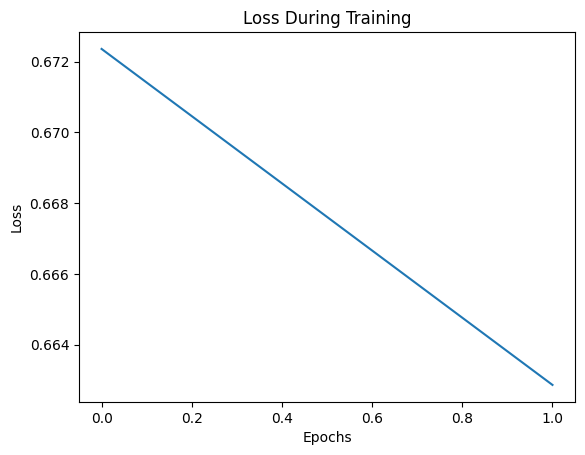

In [ ]:
from math import exp, log
import matplotlib.pyplot as plt

# Sigmoid function
def sigmoid(z):
    return 1 / (1 + exp(-z))

# Dot product of two vectors
def dot_product(a, b):
    return sum(x * y for x, y in zip(a, b))

# Predict a single sample
def predict(features, weights):
    z = dot_product(features, weights)
    return sigmoid(z)

# Compute log loss
def compute_loss(X, Y, weights):
    m = len(Y)
    loss = 0
    for i in range(m):
        x = X[i]
        y = Y[i]
        y_hat = predict(x, weights)
        loss += -y * log(y_hat + 1e-9) - (1 - y) * log(1 - y_hat + 1e-9)
    return loss / m

# Train function
def train(X, Y, lr=0.1, epochs=2):
    m, n = len(X), len(X[0])
    weights = [0.0] * n
    loss_history = []

    for epoch in range(epochs):
        gradient = [0.0] * n

        for i in range(m):
            x = X[i]
            y = Y[i]
            y_hat = predict(x, weights)

            for j in range(n):
                gradient[j] += (y_hat - y) * x[j]

        for j in range(n):
            weights[j] -= lr * gradient[j] / m

        loss = compute_loss(X, Y, weights)
        loss_history.append(loss)
        print(f"Epoch {epoch+1}, Loss: {loss:.4f}")

    return weights, loss_history


X = [[1, 2], [1, 3], [1, 4], [1, 5]]  # 1 is bias term
Y = [0, 0, 1, 1]
# Train the model
final_weights, losses = train(X, Y)
print("\nFinal weights:", final_weights)
plt.plot(losses)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss During Training")
plt.show()


[-0.004360488275524141, 0.08313833988329922]
[0.6723611223147504, 0.6628783853895602]


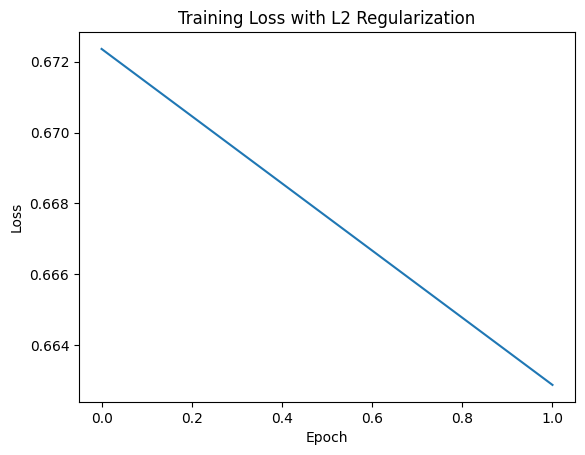

In [ ]:
import matplotlib.pyplot as plt
from math import log ,exp

# Sigmoid function
def sigmoid(z):
    return 1 / (1 + exp(-z))

# Dot product function
def dot_product(a, b):
    return sum(x * y for x, y in zip(a, b))

# Prediction using sigmoid(dot(features, weights))
def predict(features, weights):
    z = dot_product(features, weights)
    return sigmoid(z)

# Compute regularized log loss
def compute_loss(X, Y, weights, lambda_reg=0.1):
    m = len(Y)
    loss = 0
    for i in range(m):
        x = X[i]
        y = Y[i]
        y_hat = predict(x, weights)
        loss += -y * log(y_hat + 1e-9) - (1 - y) * log(1 - y_hat + 1e-9)
    # Add regularization term
    reg_term = lambda_reg * sum(w**2 for w in weights) / (2 * m)
    return loss / m + reg_term

# Training with L2 regularization
def train_with_regularization(X, Y, lr=0.01, epochs=2, lambda_reg=0.1):
    m, n = len(X), len(X[0])
    weights = [0.0] * n
    loss_history = []

    for epoch in range(epochs):
        gradient = [0.0] * n

        for i in range(m):
            x = X[i]
            y = Y[i]
            y_hat = predict(x, weights)
            for j in range(n):
                gradient[j] += (y_hat - y) * x[j] + lambda_reg * weights[j]

        for j in range(n):
            weights[j] -= lr * gradient[j] / m

        loss = compute_loss(X, Y, weights, lambda_reg)
        loss_history.append(loss)

    return weights, loss_history

X = [[1, 2], [1, 3], [1, 4], [1, 5]]  # 1 is bias term
Y = [0, 0, 1, 1]

weights, loss_history = train_with_regularization(X, Y, lr=0.1, epochs=2, lambda_reg=0.01)


print(weights)
print(loss_history)
plt.plot(loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.title("Training Loss with L2 Regularization")
plt.show()
